# Exemples de réseau à convolution

Les réseaux à convolution sont aujourd'hui utilisé dans une grande variété de tâches:

<b>Quelques exemples d'applications:</b>

### Interface utilisateur vocale: 

- Génération de automatique de voix: <a href="WaveNet">WaveNet </a>

### Traitement naturel du language

<ul>
<li>
[CNN pour la classification de Text avec Tensorflow](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)
</li>

<li>
[L'approche de Facebook pour de la traduction de Text basé sur un CNN](https://code.facebook.com/posts/1978007565818999/a-novel-approach-to-neural-machine-translation/)
</li>


</ul>


### Vison par ordinature


<ul>

<li>
[Jouer au pictionary contre un CNN](https://quickdraw.withgoogle.com/#)
</li>

<li>
[Laisser l'ia compléter vos dessins](https://www.autodraw.com/)
</li>

</ul>



# Extraction de la dataset

In [1]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

targets = []
features = []

files = glob.glob('train/*.jpg')

for file in files:
    features.append(np.array(Image.open(file).resize((75, 75))))
    target = [1, 0] if "cat" in file else [0, 1]
    targets.append(target)



features = np.array(features)
targets = np.array(targets)

print("features shape", features.shape)
print("Targets shape", targets.shape)

features shape (25000, 75, 75, 3)
Targets shape (25000, 2)


## Show image

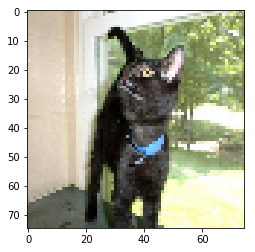

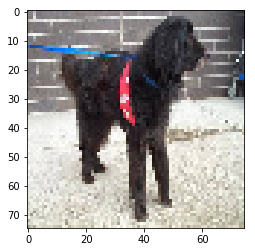

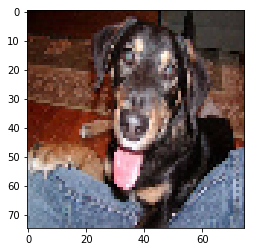

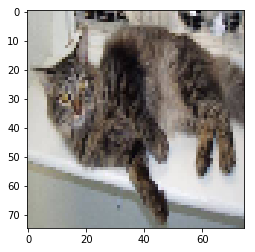

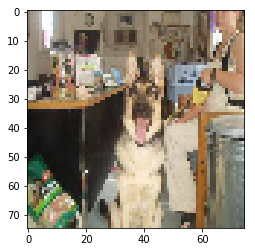

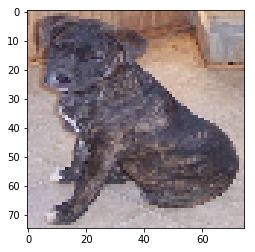

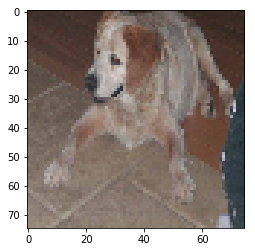

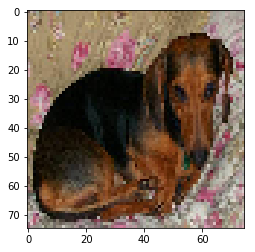

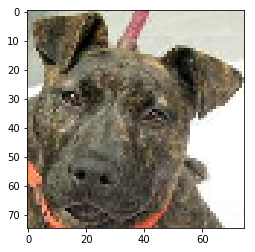

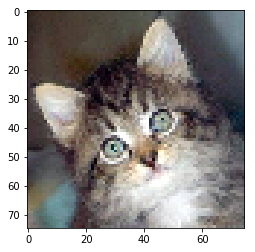

In [3]:
from random import randint

for a in [randint(0, len(features)) for _ in range(10)]:
    plt.imshow(features[a], cmap="gray")
    plt.show()

# Jeu d'entrainement / Jeu de validation

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.05, random_state=42)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (23750, 75, 75, 3)
X_valid.shape (1250, 75, 75, 3)
y_train.shape (23750, 2)
y_valid.shape (1250, 2)


## Création du modèle

In [69]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Placeholder
x = tf.placeholder(tf.float32, (None, 75, 75, 3), name="x")
y = tf.placeholder(tf.float32, (None, 2), name="y")
dropout = tf.placeholder(tf.float32, (None), name="dropout")

def create_conv(prev, filter_size, nb):
    # First convolution
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), nb)))
    conv_b = tf.Variable(tf.zeros(nb))
    conv   = tf.nn.conv2d(prev, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    # Activation: relu
    conv = tf.nn.relu(conv)
    # Pooling
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return conv

conv = create_conv(x, 8, 32)
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 128)
conv = create_conv(conv, 5, 256)
conv = create_conv(conv, 5, 215)

flat = flatten(conv)
print(flat, flat.get_shape()[1])

# First fully connected layer
fc1_W = tf.Variable(tf.truncated_normal(shape=(int(flat.get_shape()[1]), 512)))
fc1_b = tf.Variable(tf.zeros(512))
fc1   = tf.matmul(flat, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

#fc1 = tf.nn.dropout(fc1, keep_prob=dropout)

# Last layer: Prediction
fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 2)))
fc3_b  = tf.Variable(tf.zeros(2))
logits = tf.matmul(fc1, fc3_W) + fc3_b

softmax = tf.nn.softmax(logits)

Tensor("Flatten_11/Reshape:0", shape=(?, 1935), dtype=float32) 1935


## Erreur et optimisation

In [73]:
# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Accuracy
predicted_cls = tf.argmax(softmax, axis=1)
correct_prediction = tf.equal(predicted_cls, tf.argmax(y, axis=1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
training_operation = optimizer.minimize(loss_operation)

## Train the model

In [74]:
batch_size = 255

sess =  tf.Session()
sess.run(tf.global_variables_initializer())

In [75]:
from scipy import ndimage
from scipy import misc
from random import randint
import random

def augmented_batch(batch):
    """
    """
    n_batch = []
    
    for img in batch:
        if random.uniform(0, 1) > 0.75:
            process_img = Image.fromarray(np.uint8(img.reshape(75, 75, 3))).rotate(randint(-45, 45))
            n_img = np.array(process_img)
            n_batch.append(n_img.reshape(75, 75, 3))
        else:
            n_batch.append(img)
        
    return n_batch

In [ ]:
i = 0
for epoch in range(0, 10000):
    print(">> Epoch: %s" % epoch)
    # Shuffle
    indexs = np.arange(len(X_train))
    np.random.shuffle(indexs)
    X_train = X_train[indexs]
    y_train = y_train[indexs]
    
    for b in range(0, len(X_train), batch_size):
        batch = augmented_batch(X_train[b:b+batch_size])
        #batch = X_train[b:b+batch_size]

        if i % 20 == 0:
            #print(sess.run(predicted_cls, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))
            print("Accuracy [Train]:", sess.run(accuracy_operation, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))            
        sess.run(training_operation, feed_dict={dropout: 0.8, x: batch, y: y_train[b:b+batch_size]})
        i += 1

    if epoch % 2 == 0:
        accs = []
        for b in range(0, len(X_valid), batch_size):
            accs.append(sess.run(accuracy_operation, feed_dict={dropout: 1., x: X_valid[b:b+batch_size], y: y_valid[b:b+batch_size]}))
        print("Accuracy [Validation]", np.mean(accs))


>> Epoch: 0
Accuracy [Train]: 0.447059
Accuracy [Train]: 0.439216
Accuracy [Train]: 0.572549
Accuracy [Train]: 0.545098
Accuracy [Train]: 0.545098
Accuracy [Validation] 0.562541
>> Epoch: 1
Accuracy [Train]: 0.552941
Accuracy [Train]: 0.529412
Accuracy [Train]: 0.611765
Accuracy [Train]: 0.607843
Accuracy [Train]: 0.556863
>> Epoch: 2
Accuracy [Train]: 0.611765
Accuracy [Train]: 0.611765
Accuracy [Train]: 0.623529
Accuracy [Train]: 0.564706
Accuracy [Train]: 0.615686
Accuracy [Validation] 0.596266
>> Epoch: 3
Accuracy [Train]: 0.584314
Accuracy [Train]: 0.584314
Accuracy [Train]: 0.596078
Accuracy [Train]: 0.572549
>> Epoch: 4
Accuracy [Train]: 0.603922
Accuracy [Train]: 0.603922
Accuracy [Train]: 0.619608
Accuracy [Train]: 0.6
Accuracy [Train]: 0.596078
Accuracy [Validation] 0.594425
>> Epoch: 5
Accuracy [Train]: 0.592157
Accuracy [Train]: 0.627451
Accuracy [Train]: 0.603922
Accuracy [Train]: 0.572549
Accuracy [Train]: 0.635294
>> Epoch: 6
Accuracy [Train]: 0.67451
Accuracy [Train]: 0

Accuracy [Validation] 0.668542
>> Epoch: 53
Accuracy [Train]: 0.709804
Accuracy [Train]: 0.690196
Accuracy [Train]: 0.733333
Accuracy [Train]: 0.745098
>> Epoch: 54
Accuracy [Train]: 0.709804
Accuracy [Train]: 0.705882
Accuracy [Train]: 0.717647
Accuracy [Train]: 0.698039
Accuracy [Train]: 0.733333
Accuracy [Validation] 0.670111
>> Epoch: 55
Accuracy [Train]: 0.733333
Accuracy [Train]: 0.721569
Accuracy [Train]: 0.733333
Accuracy [Train]: 0.733333
Accuracy [Train]: 0.729412
>> Epoch: 56
Accuracy [Train]: 0.74902
Accuracy [Train]: 0.721569
Accuracy [Train]: 0.737255
Accuracy [Train]: 0.713726
Accuracy [Validation] 0.656181
>> Epoch: 57
Accuracy [Train]: 0.713726
Accuracy [Train]: 0.721569
Accuracy [Train]: 0.72549
Accuracy [Train]: 0.733333
Accuracy [Train]: 0.72549
>> Epoch: 58
Accuracy [Train]: 0.737255
Accuracy [Train]: 0.72549
Accuracy [Train]: 0.756863
Accuracy [Train]: 0.741176
Accuracy [Train]: 0.780392
Accuracy [Validation] 0.658875
>> Epoch: 59
Accuracy [Train]: 0.745098
Accura

Accuracy [Train]: 0.796078
Accuracy [Train]: 0.780392
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.792157
Accuracy [Validation] 0.677425
>> Epoch: 107
Accuracy [Train]: 0.854902
Accuracy [Train]: 0.823529
Accuracy [Train]: 0.780392
Accuracy [Train]: 0.854902
Accuracy [Train]: 0.8
>> Epoch: 108
Accuracy [Train]: 0.792157
Accuracy [Train]: 0.815686
Accuracy [Train]: 0.827451
Accuracy [Train]: 0.8
Accuracy [Train]: 0.760784
Accuracy [Validation] 0.65792
>> Epoch: 109
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.803922
Accuracy [Train]: 0.74902
Accuracy [Train]: 0.741176
>> Epoch: 110
Accuracy [Train]: 0.843137
Accuracy [Train]: 0.803922
Accuracy [Train]: 0.815686
Accuracy [Train]: 0.8
Accuracy [Train]: 0.847059
Accuracy [Validation] 0.662796
>> Epoch: 111
Accuracy [Train]: 0.819608
Accuracy [Train]: 0.796078
Accuracy [Train]: 0.788235
Accuracy [Train]: 0.835294
Accuracy [Train]: 0.839216
>> Epoch: 112
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.878431
Accuracy [Train]: 0.8
Accuracy [

Accuracy [Validation] 0.669599
>> Epoch: 159
Accuracy [Train]: 0.847059
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.831373
>> Epoch: 160
Accuracy [Train]: 0.843137
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.847059
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.858824
Accuracy [Validation] 0.66769
>> Epoch: 161
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.831373
Accuracy [Train]: 0.886275
Accuracy [Train]: 0.854902
Accuracy [Train]: 0.882353
>> Epoch: 162
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.870588
Accuracy [Train]: 0.843137
Accuracy [Train]: 0.866667
Accuracy [Validation] 0.676044
>> Epoch: 163
Accuracy [Train]: 0.768627
Accuracy [Train]: 0.843137
Accuracy [Train]: 0.862745
Accuracy [Train]: 0.8
>> Epoch: 164
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.835294
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.882353
Accuracy [Validation] 0.682319
>> Epoch: 165
Accuracy [Train]: 0.847059
Accur

Accuracy [Train]: 0.85098
Accuracy [Train]: 0.819608
>> Epoch: 212
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.894118
Accuracy [Train]: 0.917647
Accuracy [Validation] 0.667161
>> Epoch: 213
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.878431
Accuracy [Train]: 0.831373
>> Epoch: 214
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.878431
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.87451
Accuracy [Validation] 0.671782
>> Epoch: 215
Accuracy [Train]: 0.827451
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.894118
Accuracy [Train]: 0.85098
>> Epoch: 216
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.901961
Accuracy [Validation] 0.68058
>> Epoch: 217
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.894118
>> Epoch: 218
Accura

Accuracy [Train]: 0.882353
Accuracy [Train]: 0.854902
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.886275
Accuracy [Validation] 0.68624
>> Epoch: 265
Accuracy [Train]: 0.937255
Accuracy [Train]: 0.862745
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.878431
>> Epoch: 266
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.870588
Accuracy [Validation] 0.687366
>> Epoch: 267
Accuracy [Train]: 0.858824
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.886275
>> Epoch: 268
Accuracy [Train]: 0.823529
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.87451
Accuracy [Validation] 0.691816
>> Epoch: 269
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.862745
Accuracy [Train]: 0.917647
>> Epoch: 270
Accuracy [Train]: 0.745098
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.

Accuracy [Validation] 0.679284
>> Epoch: 317
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.823529
>> Epoch: 318
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.945098
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.937255
Accuracy [Validation] 0.693385
>> Epoch: 319
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.894118
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.917647
>> Epoch: 320
Accuracy [Train]: 0.945098
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.87451
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.952941
Accuracy [Validation] 0.69347
>> Epoch: 321
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.862745
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.882353
>> Epoch: 322
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.827451
Accuracy [Validation] 0.683717
>> Epoch: 323
Ac

Accuracy [Train]: 0.917647
Accuracy [Train]: 0.92549
>> Epoch: 370
Accuracy [Train]: 0.827451
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.878431
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.92549
Accuracy [Validation] 0.700699
>> Epoch: 371
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.921569
Accuracy [Train]: 0.905882
>> Epoch: 372
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.956863
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.882353
Accuracy [Validation] 0.680494
>> Epoch: 373
Accuracy [Train]: 0.937255
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.87451
>> Epoch: 374
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.894118
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.835294
Accuracy [Train]: 0.921569
Accuracy [Validation] 0.692515
>> Epoch: 375
Accuracy [Train]: 0.870588
Accuracy [Train]: 0.941176
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.905882
Accuracy [Train]

Accuracy [Train]: 0.905882
Accuracy [Train]: 0.933333
Accuracy [Train]: 0.941176
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.890196
Accuracy [Validation] 0.705405
>> Epoch: 423
Accuracy [Train]: 0.941176
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.933333
Accuracy [Train]: 0.894118
>> Epoch: 424
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.898039
Accuracy [Validation] 0.704092
>> Epoch: 425
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.917647
>> Epoch: 426
Accuracy [Train]: 0.94902
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.921569
Accuracy [Train]: 0.952941
Accuracy [Validation] 0.696266
>> Epoch: 427
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.937255
Accuracy [Train]: 0.933333
Accuracy [Train]: 0.945098
>> Epoch: 428
Accuracy [Train]: 0.866667
Accuracy [Train]: 0.905882
Accuracy [Train]

Accuracy [Train]: 0.913725
Accuracy [Validation] 0.692515
>> Epoch: 475
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.937255
>> Epoch: 476
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.862745
Accuracy [Train]: 0.831373
Accuracy [Validation] 0.701841
>> Epoch: 477
Accuracy [Train]: 0.847059
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.94902
Accuracy [Train]: 0.929412
>> Epoch: 478
Accuracy [Train]: 0.941176
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.937255
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.901961
Accuracy [Validation] 0.69809
>> Epoch: 479
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.94902
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.933333
>> Epoch: 480
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.898039
Accuracy [Train]: 0.85098
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.913725
Accuracy [Validation] 0.690861
>> Epoch: 481
A

Accuracy [Train]: 0.92549
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.964706
>> Epoch: 528
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.933333
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.890196
Accuracy [Validation] 0.697391
>> Epoch: 529
Accuracy [Train]: 0.921569
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.882353
>> Epoch: 530
Accuracy [Train]: 0.905882
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.901961
Accuracy [Train]: 0.882353
Accuracy [Train]: 0.909804
Accuracy [Validation] 0.704535
>> Epoch: 531
Accuracy [Train]: 0.929412
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.819608
Accuracy [Train]: 0.890196
Accuracy [Train]: 0.909804
>> Epoch: 532
Accuracy [Train]: 0.913725
Accuracy [Train]: 0.92549
Accuracy [Train]: 0.917647
Accuracy [Train]: 0.933333
Accuracy [Train]: 0.913725
Accuracy [Validation] 0.692089
>> Epoch: 533
Accuracy [Train]: 0.909804
Accuracy [Train]: 0.921569
Accuracy [Train]: 0.878431
Accuracy [Train]: